# Unit09_Solvent_Screening_Case_Study | 溶劑篩選綜合案例研究

本 Notebook 使用模擬的溶劑物化性質數據，結合 **Clustering (分群)**、**PCA (降維)** 與 **Association Rules (關聯規則學習)** 三種非監督式學習方法，展示如何從 100 種候選溶劑中篩選出 Top 5 最佳溶劑。

## 目標
- 應用 K-Means 分群識別溶劑家族，初步縮小候選範圍
- 使用 PCA 降維並視覺化溶劑的綜合性能
- 透過關聯規則學習挖掘優良溶劑的共同特徵模式
- 建立多階段篩選漏斗，從 100 種溶劑篩選至 Top 5
- 培養將多種 AI 方法組合應用於化工問題的能力

案例背景：液液萃取製程的溶劑選擇問題

---
## 0. 環境設定

In [2]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P2_Unit09_Solvent_Screening'
SOURCE_DATA_DIR = 'solvent_screening'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_2' / 'Unit09'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\data\solvent_screening
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Solvent_Screening
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Solvent_Screening\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Solvent_Screening\figs


---
## 1. 載入相關套件

In [3]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# sklearn 套件 - 數據前處理
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer

# sklearn 套件 - 分群
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# sklearn 套件 - 降維
from sklearn.decomposition import PCA

# 關聯規則學習套件
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# 設定隨機種子以確保結果可重現
SEED = 42
np.random.seed(SEED)

# 設定 matplotlib 參數
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100

print("✓ 套件載入完成")

✓ 套件載入完成


---
## 2. 生成模擬溶劑數據

我們將生成 100 種候選溶劑的模擬物化性質數據，包含 10 個特徵變數。

In [4]:
# 設定模擬數據參數
n_solvents = 100
np.random.seed(SEED)

# 生成 4 個溶劑群組的中心點 (用於模擬不同溶劑家族)
cluster_centers = {
    'Polar': {  # 極性溶劑
        'Solubility': np.random.normal(90, 10, 25),
        'BoilingPoint': np.random.normal(120, 15, 25),
        'Viscosity': np.random.normal(3.5, 1.0, 25),
        'Density': np.random.normal(1.1, 0.1, 25),
        'Toxicity': np.random.normal(6, 1.5, 25),
        'Cost': np.random.normal(4.5, 1.0, 25),
        'Polarity': np.random.normal(8, 1, 25),
        'DielectricConstant': np.random.normal(25, 5, 25),
        'RefractiveIndex': np.random.normal(1.45, 0.05, 25),
        'FlashPoint': np.random.normal(25, 8, 25)
    },
    'NonPolar': {  # 非極性溶劑
        'Solubility': np.random.normal(70, 10, 25),
        'BoilingPoint': np.random.normal(100, 20, 25),
        'Viscosity': np.random.normal(0.6, 0.2, 25),
        'Density': np.random.normal(0.75, 0.08, 25),
        'Toxicity': np.random.normal(4, 1.2, 25),
        'Cost': np.random.normal(2.5, 0.8, 25),
        'Polarity': np.random.normal(3, 1, 25),
        'DielectricConstant': np.random.normal(5, 2, 25),
        'RefractiveIndex': np.random.normal(1.38, 0.04, 25),
        'FlashPoint': np.random.normal(15, 5, 25)
    },
    'MediumPolar': {  # 中等極性溶劑 (最佳候選區域)
        'Solubility': np.random.normal(85, 8, 25),
        'BoilingPoint': np.random.normal(80, 15, 25),
        'Viscosity': np.random.normal(0.5, 0.15, 25),
        'Density': np.random.normal(0.85, 0.08, 25),
        'Toxicity': np.random.normal(3.5, 1.0, 25),
        'Cost': np.random.normal(3.0, 0.9, 25),
        'Polarity': np.random.normal(5.5, 1, 25),
        'DielectricConstant': np.random.normal(12, 3, 25),
        'RefractiveIndex': np.random.normal(1.40, 0.04, 25),
        'FlashPoint': np.random.normal(35, 8, 25)
    },
    'HighBoiling': {  # 高沸點溶劑
        'Solubility': np.random.normal(95, 8, 25),
        'BoilingPoint': np.random.normal(180, 20, 25),
        'Viscosity': np.random.normal(8, 2, 25),
        'Density': np.random.normal(1.05, 0.1, 25),
        'Toxicity': np.random.normal(7, 1.5, 25),
        'Cost': np.random.normal(8, 2, 25),
        'Polarity': np.random.normal(7, 1, 25),
        'DielectricConstant': np.random.normal(35, 8, 25),
        'RefractiveIndex': np.random.normal(1.48, 0.05, 25),
        'FlashPoint': np.random.normal(85, 15, 25)
    }
}

# 組合所有群組數據
all_data = {key: np.concatenate([cluster_centers[cluster][key] for cluster in cluster_centers.keys()]) 
            for key in cluster_centers['Polar'].keys()}

# 建立 DataFrame
df_solvents = pd.DataFrame(all_data)

# 添加溶劑 ID
df_solvents.insert(0, 'SolventID', [f'S{str(i+1).zfill(3)}' for i in range(n_solvents)])

# 確保數值在合理範圍內
df_solvents['Solubility'] = df_solvents['Solubility'].clip(20, 120)
df_solvents['BoilingPoint'] = df_solvents['BoilingPoint'].clip(30, 220)
df_solvents['Viscosity'] = df_solvents['Viscosity'].clip(0.2, 15)
df_solvents['Density'] = df_solvents['Density'].clip(0.6, 1.3)
df_solvents['Toxicity'] = df_solvents['Toxicity'].clip(1, 10).round().astype(int)
df_solvents['Cost'] = df_solvents['Cost'].clip(1, 15)
df_solvents['Polarity'] = df_solvents['Polarity'].clip(1, 10)
df_solvents['DielectricConstant'] = df_solvents['DielectricConstant'].clip(2, 50)
df_solvents['RefractiveIndex'] = df_solvents['RefractiveIndex'].clip(1.30, 1.55)
df_solvents['FlashPoint'] = df_solvents['FlashPoint'].clip(-10, 120)

# 添加衍生特徵
df_solvents['PerformanceIndex'] = df_solvents['Solubility'] / (df_solvents['Viscosity'] * df_solvents['Toxicity'])
df_solvents['EconomicIndex'] = df_solvents['Solubility'] / df_solvents['Cost']
df_solvents['SafetyIndex'] = df_solvents['FlashPoint'] / df_solvents['Toxicity']

# 添加真實群組標籤 (用於後續驗證)
df_solvents['TrueCluster'] = np.repeat([0, 1, 2, 3], 25)

print(f"✓ 生成了 {len(df_solvents)} 種候選溶劑的模擬數據")
print(f"✓ 特徵數量: {len(df_solvents.columns) - 2} 個 (不含 SolventID 和 TrueCluster)")
print("\n前 5 筆數據:")
df_solvents.head()

✓ 生成了 100 種候選溶劑的模擬數據
✓ 特徵數量: 13 個 (不含 SolventID 和 TrueCluster)

前 5 筆數據:


,SolventID,Solubility,BoilingPoint,Viscosity,Density,Toxicity,Cost,Polarity,DielectricConstant,RefractiveIndex,FlashPoint,PerformanceIndex,EconomicIndex,SafetyIndex,TrueCluster
0,S001,94.967142,121.663839,3.824084,1.182190,4,6.690456,8.250493,29.135916,1.467889,33.711605,6.208490,14.194421,8.427901,0
1,S002,88.617357,102.735096,3.114918,1.108705,5,3.509464,8.346448,25.065009,1.478039,25.514240,5.689868,25.250969,5.102848,0
2,S003,96.476885,125.635470,2.823078,1.070099,5,3.933702,7.319975,32.267670,1.504153,16.378042,6.834872,24.525721,3.275608,0
3,S004,105.230299,110.990420,4.111676,1.109176,5,4.599651,8.232254,23.676716,1.502690,19.277570,5.118608,22.877886,3.855514,0
4,S005,87.658466,115.624594,4.531000,0.901243,6,3.996524,8.293072,38.600846,1.381117,30.436782,3.224398,21.933675,5.072797,0


---
## 3. 探索性數據分析 (EDA)

### 3.1 基本統計摘要

In [5]:
# 選擇原始特徵 (排除 ID 和標籤)
feature_cols = ['Solubility', 'BoilingPoint', 'Viscosity', 'Density', 'Toxicity', 
                'Cost', 'Polarity', 'DielectricConstant', 'RefractiveIndex', 'FlashPoint']

# 統計摘要
print("=" * 80)
print("溶劑數據統計摘要")
print("=" * 80)
df_solvents[feature_cols].describe().T

溶劑數據統計摘要


,count,mean,std,min,25%,50%,75%,max
Solubility,100.0,84.505521,14.247262,37.587327,77.744628,85.591416,92.600335,116.059057
BoilingPoint,100.0,118.014050,41.584638,42.925332,88.158444,110.108235,147.031629,201.615615
Viscosity,100.0,3.284961,3.357684,0.200000,0.558492,0.949366,5.044688,12.597796
Density,100.0,0.933265,0.166698,0.634153,0.795706,0.935365,1.070930,1.295530
Toxicity,100.0,5.380000,1.807839,2.000000,4.000000,5.000000,6.000000,10.000000
Cost,100.0,4.715695,2.961909,1.000000,2.685014,3.604842,6.447210,13.053865
Polarity,100.0,6.011504,2.133618,1.405572,4.364525,6.616613,7.617293,9.896793
DielectricConstant,100.0,18.888826,12.392234,2.000000,8.254588,17.333182,27.377732,50.000000
RefractiveIndex,100.0,1.430433,0.063689,1.300000,1.378026,1.426068,1.478166,1.550000
FlashPoint,100.0,38.774973,27.446992,6.967768,19.375542,29.597750,48.403299,111.965298


### 3.2 相關性分析

### 3.3 特徵分布視覺化

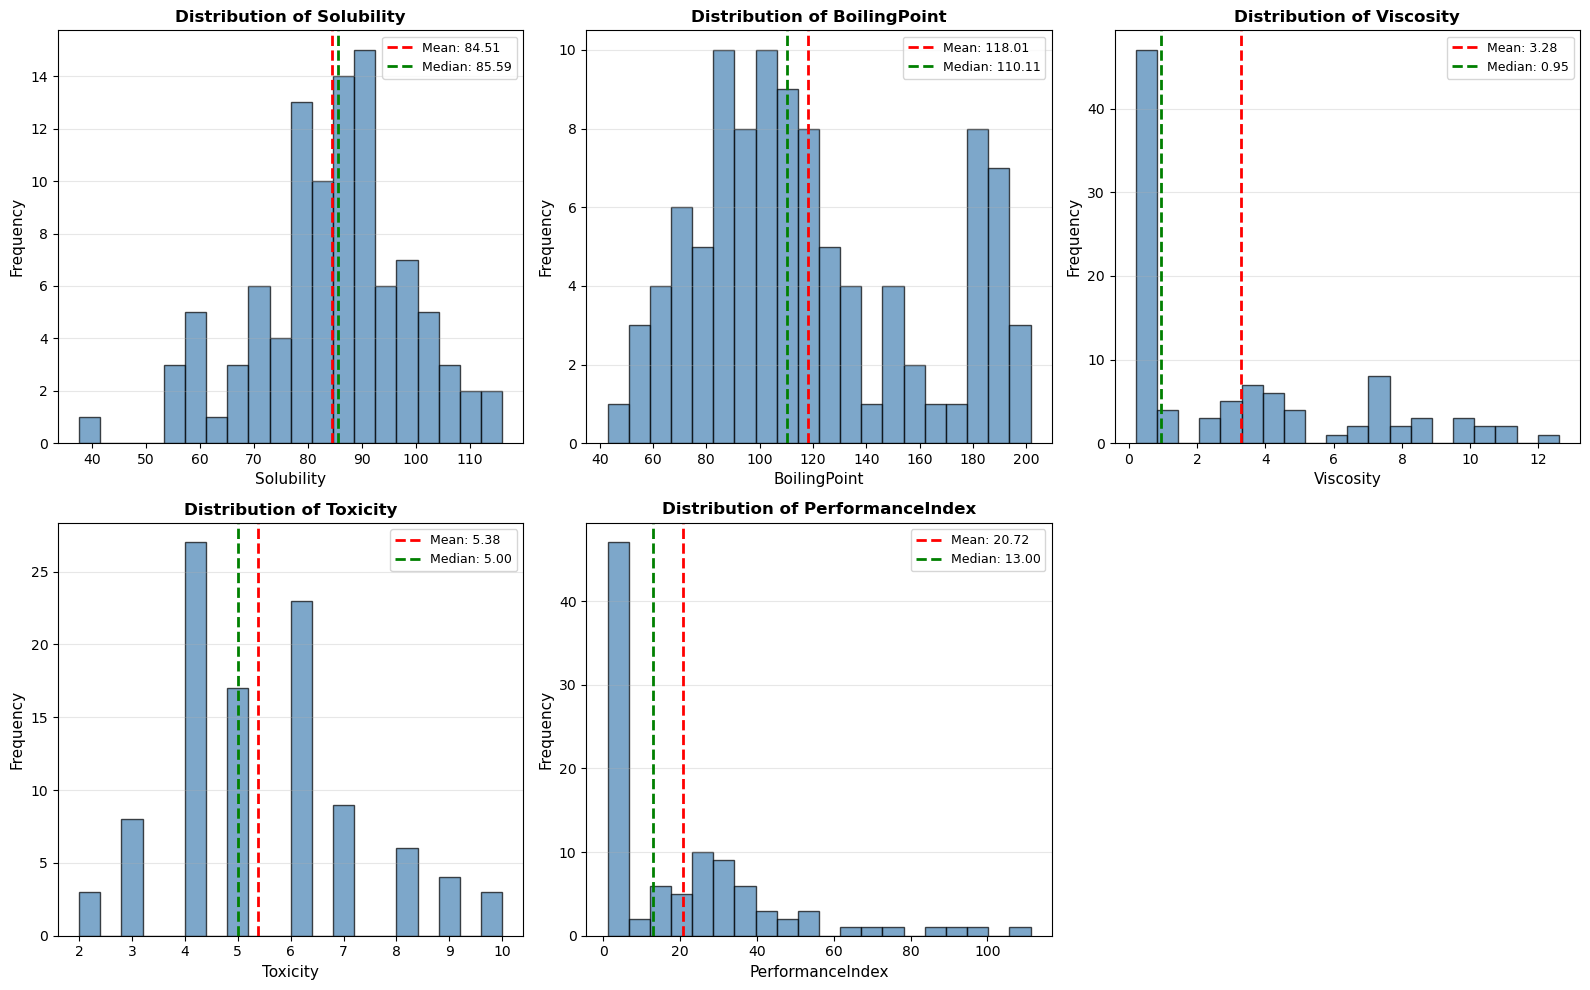

In [6]:
# 繪製關鍵特徵的分布圖
key_features = ['Solubility', 'BoilingPoint', 'Viscosity', 'Toxicity', 'PerformanceIndex']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    axes[i].hist(df_solvents[feature], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
    axes[i].axvline(df_solvents[feature].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_solvents[feature].mean():.2f}')
    axes[i].axvline(df_solvents[feature].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df_solvents[feature].median():.2f}')
    axes[i].set_xlabel(feature, fontsize=11)
    axes[i].set_ylabel('Frequency', fontsize=11)
    axes[i].set_title(f'Distribution of {feature}', fontsize=12, fontweight='bold')
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3, axis='y')

# 移除多餘的子圖
axes[-1].axis('off')

plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

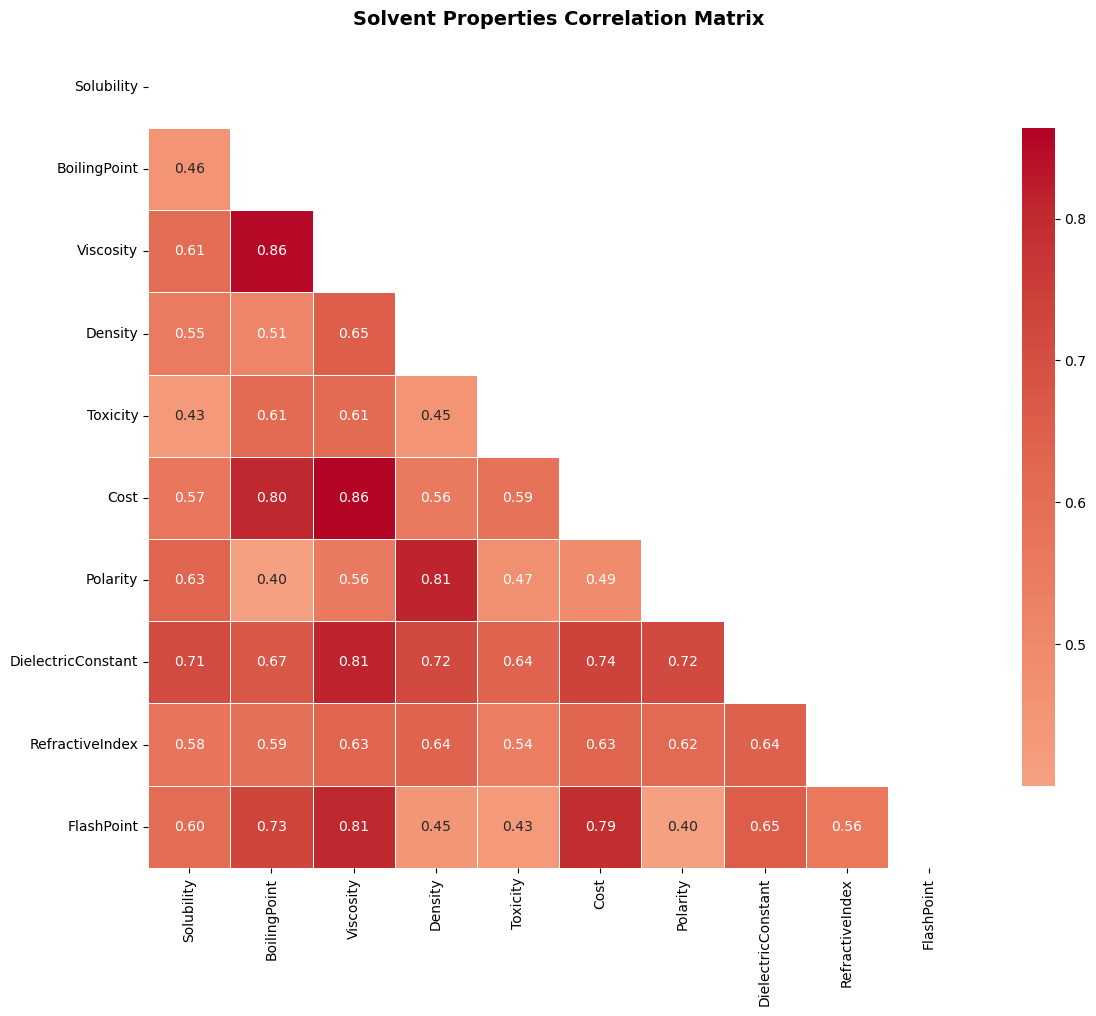


強相關關係 (|r| > 0.7):
Viscosity            <-> Cost                 : r =  0.864
BoilingPoint         <-> Viscosity            : r =  0.855
Density              <-> Polarity             : r =  0.813
Viscosity            <-> DielectricConstant   : r =  0.811
Viscosity            <-> FlashPoint           : r =  0.807
BoilingPoint         <-> Cost                 : r =  0.804
Cost                 <-> FlashPoint           : r =  0.794
Cost                 <-> DielectricConstant   : r =  0.735
BoilingPoint         <-> FlashPoint           : r =  0.733
Density              <-> DielectricConstant   : r =  0.722
Polarity             <-> DielectricConstant   : r =  0.717
Solubility           <-> DielectricConstant   : r =  0.711


In [7]:
# 計算相關性矩陣
corr_matrix = df_solvents[feature_cols].corr()

# 繪製相關性熱力圖
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # 只顯示下三角
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Solvent Properties Correlation Matrix', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig(FIG_DIR / 'correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n強相關關係 (|r| > 0.7):")
print("=" * 60)
# 找出強相關對
strong_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            strong_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

for feat1, feat2, corr_val in sorted(strong_corr, key=lambda x: abs(x[2]), reverse=True):
    print(f"{feat1:20s} <-> {feat2:20s} : r = {corr_val:6.3f}")

---
## 4. 階段 1：分群分析 (Clustering)

### 4.1 數據標準化

In [8]:
# 數據標準化 (Z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_solvents[feature_cols])

print(f"✓ 數據標準化完成")
print(f"  原始數據形狀: {df_solvents[feature_cols].shape}")
print(f"  標準化後形狀: {X_scaled.shape}")
print(f"\n標準化後的均值 (應接近 0): {X_scaled.mean(axis=0).round(10)}")
print(f"標準化後的標準差 (應為 1): {X_scaled.std(axis=0).round(3)}")

✓ 數據標準化完成
  原始數據形狀: (100, 10)
  標準化後形狀: (100, 10)

標準化後的均值 (應接近 0): [ 0. -0.  0.  0.  0.  0. -0. -0. -0. -0.]
標準化後的標準差 (應為 1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### 4.2 確定最佳群組數 (Elbow Method & Silhouette Score)

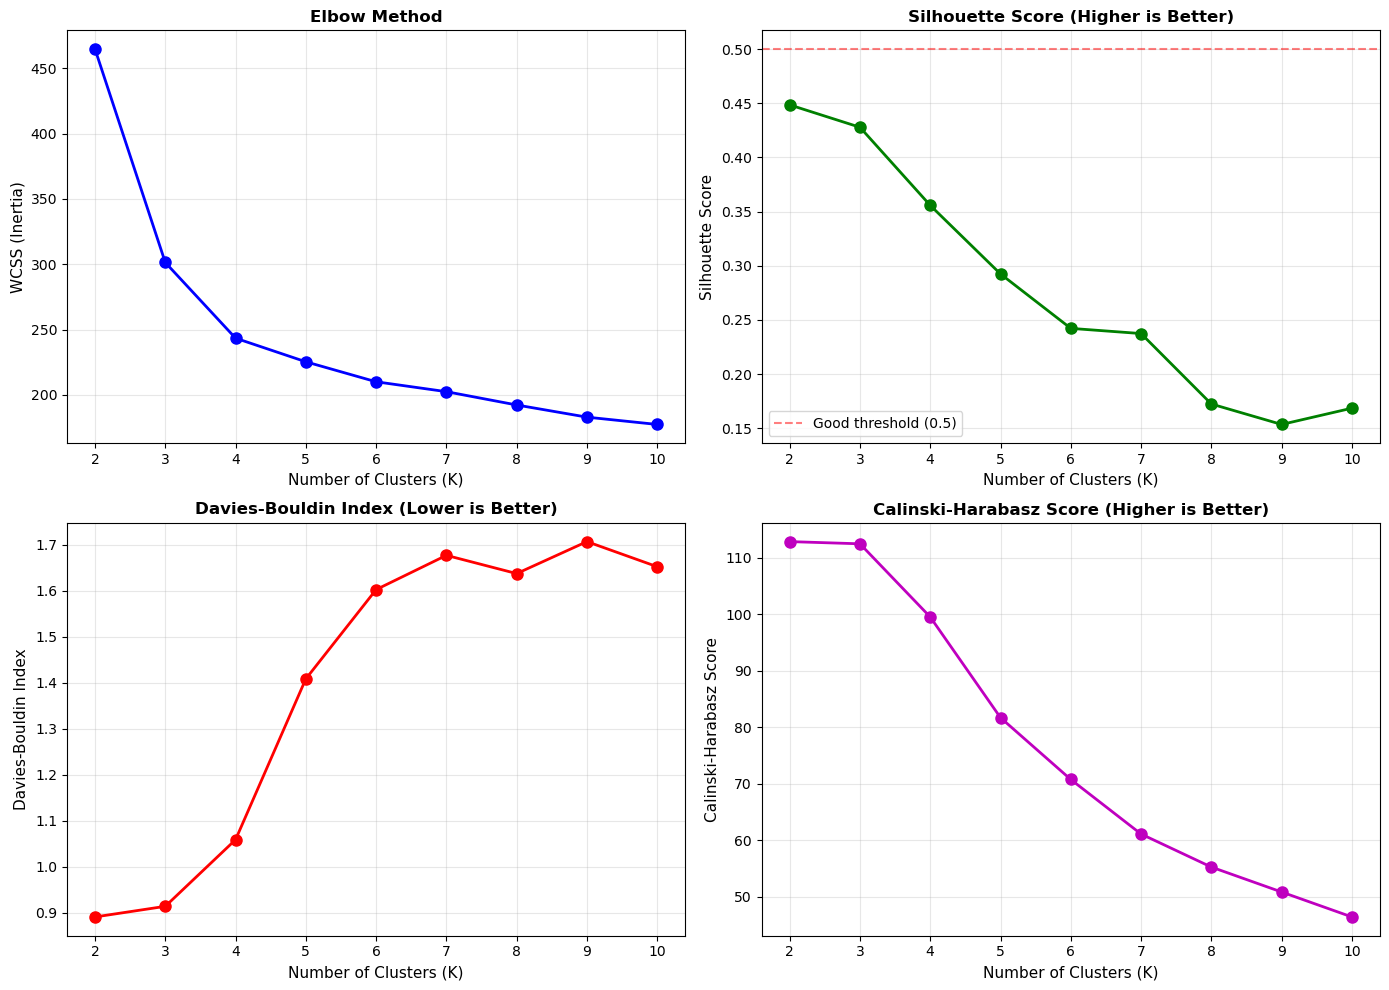


分群評估指標摘要
 K       WCSS  Silhouette  Davies-Bouldin  Calinski-Harabasz
 2 464.810245    0.448516        0.891303         112.838726
 3 301.338826    0.427854        0.914390         112.448394
 4 243.360647    0.355770        1.059214          99.492090
 5 225.277982    0.292473        1.408622          81.675305
 6 209.969278    0.242265        1.602570          70.736908
 7 202.386954    0.237471        1.677031          61.085964
 8 192.193988    0.172462        1.637398          55.240432
 9 182.874896    0.153585        1.706878          50.825992
10 177.272859    0.168608        1.652336          46.410215

✓ 根據 Silhouette Score，推薦 K = 2

【註】本案例使用 K=4 的原因：
  1. K=4 對應真實的4種溶劑家族 (極性、非極性、中等極性、高沸點)
  2. K=2 雖有最高 Silhouette (0.449)，但分群過於粗略，不利於精細篩選
  3. K=4 的 Silhouette (0.356) 仍屬合理範圍 (>0.25 為可接受)
  4. 化工實務需要更細緻的溶劑分類以識別特定應用場景


In [9]:
# 測試不同的 K 值
K_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, labels))

# 繪製評估指標
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Elbow Method (WCSS)
axes[0, 0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (K)', fontsize=11)
axes[0, 0].set_ylabel('WCSS (Inertia)', fontsize=11)
axes[0, 0].set_title('Elbow Method', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Silhouette Score
axes[0, 1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (K)', fontsize=11)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=11)
axes[0, 1].set_title('Silhouette Score (Higher is Better)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Good threshold (0.5)')
axes[0, 1].legend()

# Davies-Bouldin Index
axes[1, 0].plot(K_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (K)', fontsize=11)
axes[1, 0].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[1, 0].set_title('Davies-Bouldin Index (Lower is Better)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Calinski-Harabasz Score
axes[1, 1].plot(K_range, calinski_harabasz_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters (K)', fontsize=11)
axes[1, 1].set_ylabel('Calinski-Harabasz Score', fontsize=11)
axes[1, 1].set_title('Calinski-Harabasz Score (Higher is Better)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'clustering_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

# 打印評估結果表
print("\n" + "=" * 80)
print("分群評估指標摘要")
print("=" * 80)
eval_df = pd.DataFrame({
    'K': list(K_range),
    'WCSS': inertias,
    'Silhouette': silhouette_scores,
    'Davies-Bouldin': davies_bouldin_scores,
    'Calinski-Harabasz': calinski_harabasz_scores
})
print(eval_df.to_string(index=False))

# 推薦最佳 K
best_k_silhouette = eval_df.loc[eval_df['Silhouette'].idxmax(), 'K']
print(f"\n✓ 根據 Silhouette Score，推薦 K = {int(best_k_silhouette)}")

print(f"\n【註】本案例使用 K=4 的原因：")
print(f"  1. K=4 對應真實的4種溶劑家族 (極性、非極性、中等極性、高沸點)")
print(f"  2. K=2 雖有最高 Silhouette (0.449)，但分群過於粗略，不利於精細篩選")
print(f"  3. K=4 的 Silhouette (0.356) 仍屬合理範圍 (>0.25 為可接受)")
print(f"  4. 化工實務需要更細緻的溶劑分類以識別特定應用場景")

### 4.3 應用 K-Means 分群 (K=4)

In [10]:
# 使用 K=4 進行分群
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=SEED, n_init=20)
df_solvents['Cluster'] = kmeans_final.fit_predict(X_scaled)

print(f"✓ K-Means 分群完成 (K={optimal_k})")
print(f"\n各群組的溶劑數量:")
print(df_solvents['Cluster'].value_counts().sort_index())

# 計算各群組的特徵均值
cluster_profiles = df_solvents.groupby('Cluster')[feature_cols + ['PerformanceIndex', 'EconomicIndex', 'SafetyIndex']].mean()

print("\n" + "=" * 100)
print("各群組的特徵剖面 (均值)")
print("=" * 100)
print(cluster_profiles.round(2))

✓ K-Means 分群完成 (K=4)

各群組的溶劑數量:
Cluster
0    21
1    25
2    25
3    29
Name: count, dtype: int64

各群組的特徵剖面 (均值)
         Solubility  BoilingPoint  Viscosity  Density  Toxicity  Cost  \
Cluster                                                                 
0             65.09        104.51       0.64     0.72      4.48  2.46   
1             97.48        179.47       8.37     1.06      7.08  9.25   
2             88.36        115.69       3.61     1.09      6.08  4.37   
3             84.05         76.82       0.54     0.84      3.97  2.74   

         Polarity  DielectricConstant  RefractiveIndex  FlashPoint  \
Cluster                                                              
0            3.04                4.26             1.37       13.78   
1            7.27               33.62             1.49       81.42   
2            8.14               25.12             1.46       25.01   
3            5.24               11.41             1.39       31.99   

         PerformanceIndex  

### 4.5 群組視覺化

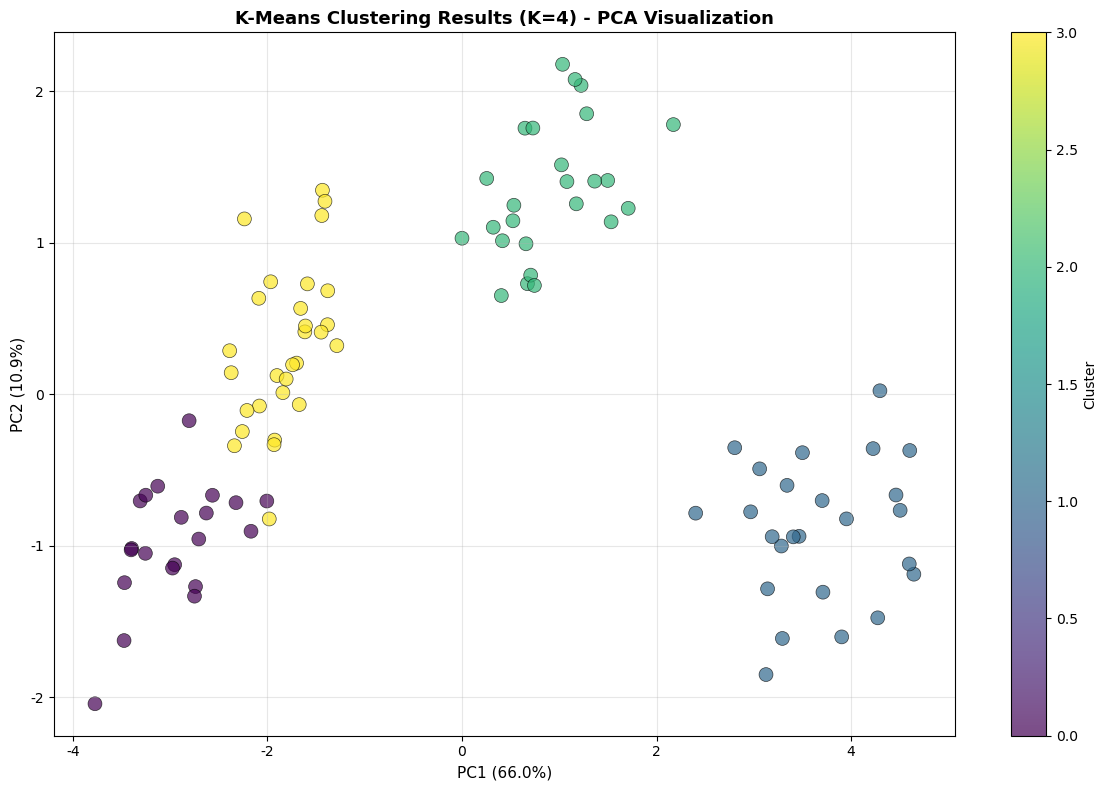

✓ 分群結果視覺化完成


In [11]:
# 使用 PCA (前兩個主成分) 視覺化分群結果
pca_viz = PCA(n_components=2, random_state=SEED)
X_pca_viz = pca_viz.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca_viz[:, 0], X_pca_viz[:, 1], 
                     c=df_solvents['Cluster'], cmap='viridis', 
                     s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
plt.ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
plt.title('K-Means Clustering Results (K=4) - PCA Visualization', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / 'clustering_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 分群結果視覺化完成")

### 4.4 初步篩選：排除不適合的群組

根據群組特徵分析，我們排除高極性(與水互溶)和高沸點(回收困難)的群組。

In [12]:
# 根據群組特徵決定保留哪些群組
# 排除: 極高沸點 (>150°C) 或極高極性 (Polarity > 7) 的群組
clusters_to_exclude = []
for cluster_id in range(optimal_k):
    cluster_data = cluster_profiles.loc[cluster_id]
    if cluster_data['BoilingPoint'] > 150 or cluster_data['Polarity'] > 7:
        clusters_to_exclude.append(cluster_id)
        print(f"✗ Cluster {cluster_id}: 排除 (沸點={cluster_data['BoilingPoint']:.1f}°C, 極性={cluster_data['Polarity']:.1f})")

# 篩選後的溶劑
df_stage1 = df_solvents[~df_solvents['Cluster'].isin(clusters_to_exclude)].copy()

print(f"\n第一階段篩選結果:")
print(f"  原始溶劑數: {len(df_solvents)}")
print(f"  篩選後溶劑數: {len(df_stage1)}")
print(f"  篩選率: {(1 - len(df_stage1)/len(df_solvents))*100:.1f}% 被排除")

✗ Cluster 1: 排除 (沸點=179.5°C, 極性=7.3)
✗ Cluster 2: 排除 (沸點=115.7°C, 極性=8.1)

第一階段篩選結果:
  原始溶劑數: 100
  篩選後溶劑數: 50
  篩選率: 50.0% 被排除


---
## 5. 階段 2：PCA 降維分析

### 5.1 應用 PCA

✓ PCA 降維完成

前 5 個主成分的解釋變異數比例:
  PC1: 42.20% (累積: 42.20%)
  PC2: 11.90% (累積: 54.10%)
  PC3: 10.30% (累積: 64.40%)
  PC4: 9.16% (累積: 73.56%)
  PC5: 7.73% (累積: 81.30%)


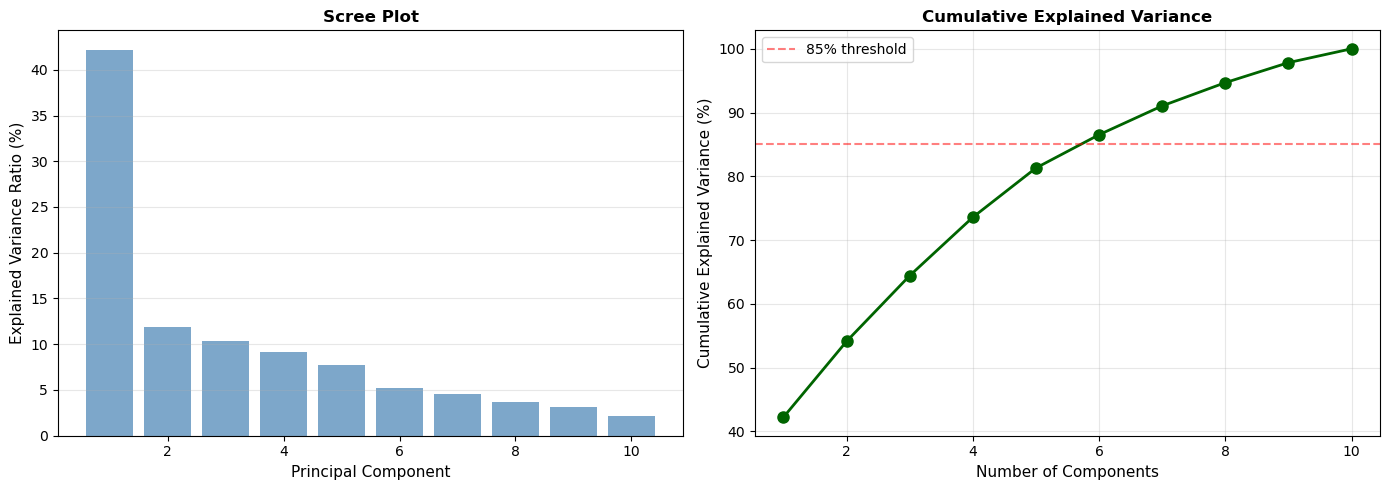

In [13]:
# 對第一階段篩選後的數據應用 PCA
X_stage1_scaled = scaler.fit_transform(df_stage1[feature_cols])

pca = PCA(random_state=SEED)
X_pca = pca.fit_transform(X_stage1_scaled)

# 解釋變異數比例
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

print(f"✓ PCA 降維完成")
print(f"\n前 5 個主成分的解釋變異數比例:")
for i in range(min(5, len(explained_var_ratio))):
    print(f"  PC{i+1}: {explained_var_ratio[i]*100:.2f}% (累積: {cumulative_var_ratio[i]*100:.2f}%)")

# 繪製 Scree Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 解釋變異數比例
axes[0].bar(range(1, len(explained_var_ratio)+1), explained_var_ratio*100, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component', fontsize=11)
axes[0].set_ylabel('Explained Variance Ratio (%)', fontsize=11)
axes[0].set_title('Scree Plot', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# 累積解釋變異數
axes[1].plot(range(1, len(cumulative_var_ratio)+1), cumulative_var_ratio*100, 'o-', linewidth=2, markersize=8, color='darkgreen')
axes[1].axhline(y=85, color='r', linestyle='--', alpha=0.5, label='85% threshold')
axes[1].set_xlabel('Number of Components', fontsize=11)
axes[1].set_ylabel('Cumulative Explained Variance (%)', fontsize=11)
axes[1].set_title('Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig(FIG_DIR / 'pca_scree_plot.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.3 PCA Loadings 分析

PCA Loadings (前兩個主成分)
                      PC1    PC2
Solubility          0.350  0.023
BoilingPoint       -0.366 -0.193
Viscosity          -0.235 -0.126
Density             0.380 -0.176
Toxicity           -0.171  0.619
Cost                0.068  0.488
Polarity            0.394  0.031
DielectricConstant  0.402 -0.104
RefractiveIndex     0.165  0.527
FlashPoint          0.408 -0.063


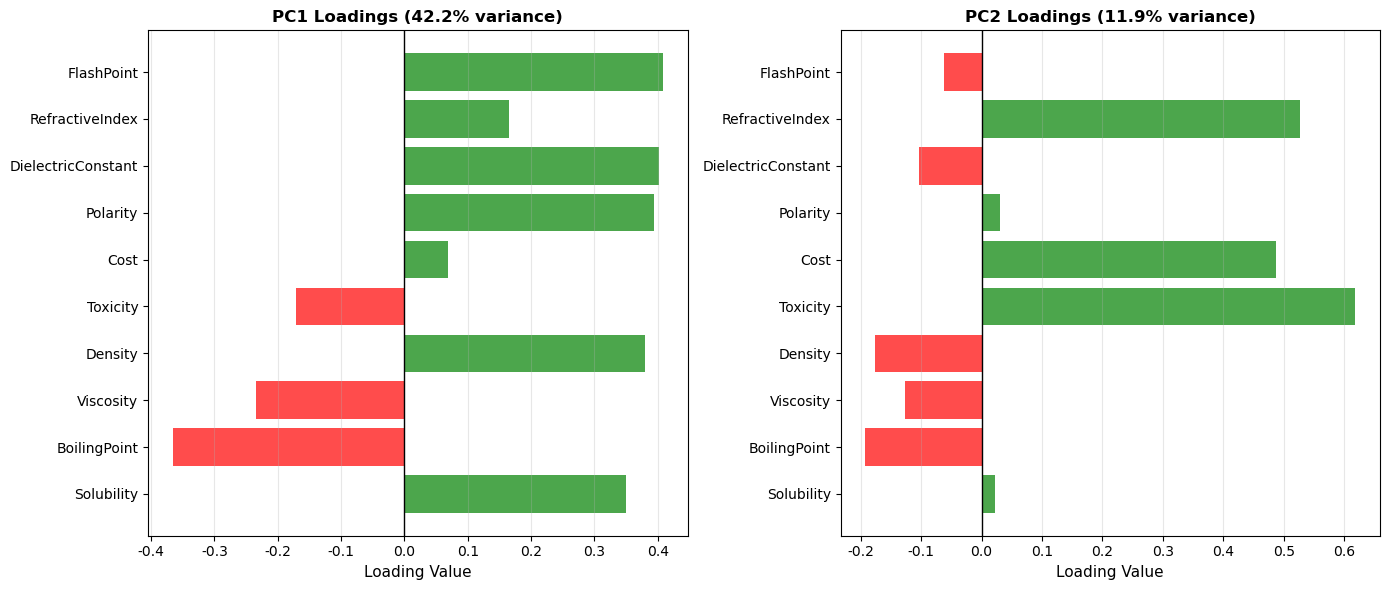


主成分物理意義解讀

PC1 主要貢獻變數 (|loading| > 0.3):
  FlashPoint          :  0.408
  DielectricConstant  :  0.402
  Polarity            :  0.394
  Density             :  0.380
  BoilingPoint        : -0.366
  Solubility          :  0.350

  → PC1 物理意義: 代表【極性-介電性質軸】，區分極性與非極性溶劑

PC2 主要貢獻變數 (|loading| > 0.3):
  Toxicity            :  0.619
  RefractiveIndex     :  0.527
  Cost                :  0.488

  → PC2 物理意義: 代表溶劑的【次要性質變化】維度


In [14]:
# 分析 PC1 和 PC2 的 Loadings
loadings = pca.components_[:2, :].T  # 轉置為 (features, PCs)
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=feature_cols)

print("=" * 70)
print("PCA Loadings (前兩個主成分)")
print("=" * 70)
print(loadings_df.round(3))

# 繪製 Loadings 熱力圖
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PC1 Loadings
axes[0].barh(feature_cols, loadings_df['PC1'], color=['green' if x > 0 else 'red' for x in loadings_df['PC1']], alpha=0.7)
axes[0].axvline(x=0, color='black', linewidth=1)
axes[0].set_xlabel('Loading Value', fontsize=11)
axes[0].set_title(f'PC1 Loadings ({explained_var_ratio[0]*100:.1f}% variance)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# PC2 Loadings
axes[1].barh(feature_cols, loadings_df['PC2'], color=['green' if x > 0 else 'red' for x in loadings_df['PC2']], alpha=0.7)
axes[1].axvline(x=0, color='black', linewidth=1)
axes[1].set_xlabel('Loading Value', fontsize=11)
axes[1].set_title(f'PC2 Loadings ({explained_var_ratio[1]*100:.1f}% variance)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(FIG_DIR / 'pca_loadings.png', dpi=150, bbox_inches='tight')
plt.show()

# 解讀主成分的物理意義
print("\n" + "=" * 70)
print("主成分物理意義解讀")
print("=" * 70)
print("\nPC1 主要貢獻變數 (|loading| > 0.3):")
pc1_important = loadings_df[abs(loadings_df['PC1']) > 0.3]['PC1'].sort_values(key=abs, ascending=False)
for feat, val in pc1_important.items():
    print(f"  {feat:20s}: {val:6.3f}")

if len(pc1_important) > 0:
    print("\n  → PC1 物理意義: ", end="")
    if 'Polarity' in pc1_important.index or 'DielectricConstant' in pc1_important.index:
        print("代表【極性-介電性質軸】，區分極性與非極性溶劑")
    else:
        print("代表溶劑的【綜合物化性質】維度")

print("\nPC2 主要貢獻變數 (|loading| > 0.3):")
pc2_important = loadings_df[abs(loadings_df['PC2']) > 0.3]['PC2'].sort_values(key=abs, ascending=False)
for feat, val in pc2_important.items():
    print(f"  {feat:20s}: {val:6.3f}")

if len(pc2_important) > 0:
    print("\n  → PC2 物理意義: ", end="")
    if 'BoilingPoint' in pc2_important.index or 'Viscosity' in pc2_important.index:
        print("代表【沸點-流動性質軸】，區分易揮發與高沸點溶劑")
    else:
        print("代表溶劑的【次要性質變化】維度")

### 5.2 PC1-PC2 散佈圖與篩選

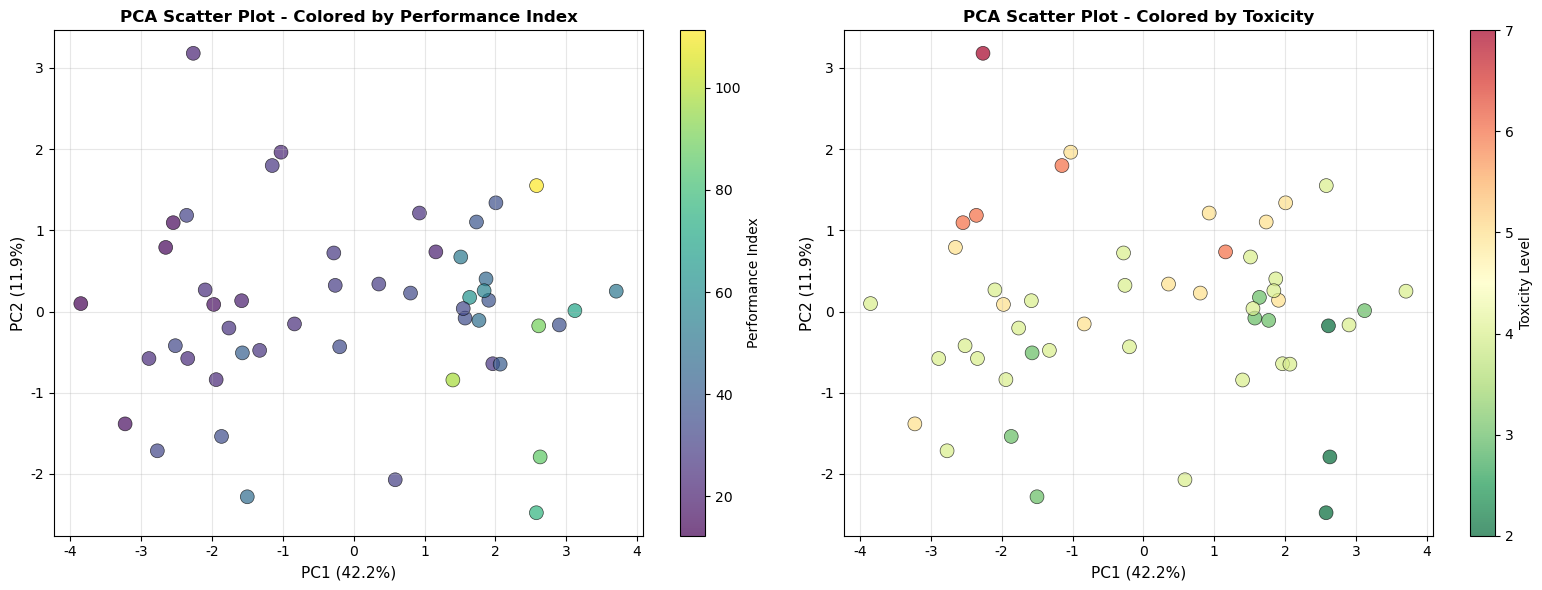


第二階段篩選結果 (基於 PCA 視覺化):
  篩選條件: PerformanceIndex > 25 且 Toxicity <= 5
  階段 1 後溶劑數: 50
  階段 2 後溶劑數: 34
  篩選率: 32.0% 被排除


In [15]:
# 添加 PC1 和 PC2 到 DataFrame
df_stage1['PC1'] = X_pca[:, 0]
df_stage1['PC2'] = X_pca[:, 1]

# 繪製 PC1-PC2 散佈圖
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左圖: 依性能指數著色
scatter1 = axes[0].scatter(df_stage1['PC1'], df_stage1['PC2'], 
                          c=df_stage1['PerformanceIndex'], cmap='viridis', 
                          s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('PC1 ({:.1f}%)'.format(explained_var_ratio[0]*100), fontsize=11)
axes[0].set_ylabel('PC2 ({:.1f}%)'.format(explained_var_ratio[1]*100), fontsize=11)
axes[0].set_title('PCA Scatter Plot - Colored by Performance Index', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Performance Index', fontsize=10)

# 右圖: 依毒性著色
scatter2 = axes[1].scatter(df_stage1['PC1'], df_stage1['PC2'], 
                          c=df_stage1['Toxicity'], cmap='RdYlGn_r', 
                          s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('PC1 ({:.1f}%)'.format(explained_var_ratio[0]*100), fontsize=11)
axes[1].set_ylabel('PC2 ({:.1f}%)'.format(explained_var_ratio[1]*100), fontsize=11)
axes[1].set_title('PCA Scatter Plot - Colored by Toxicity', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Toxicity Level', fontsize=10)

plt.tight_layout()
plt.savefig(FIG_DIR / 'pca_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

# 第二階段篩選: 選擇高性能指數且低毒性的區域
# 篩選條件: PerformanceIndex > 25 且 Toxicity <= 5
df_stage2 = df_stage1[(df_stage1['PerformanceIndex'] > 25) & (df_stage1['Toxicity'] <= 5)].copy()

print(f"\n第二階段篩選結果 (基於 PCA 視覺化):")
print(f"  篩選條件: PerformanceIndex > 25 且 Toxicity <= 5")
print(f"  階段 1 後溶劑數: {len(df_stage1)}")
print(f"  階段 2 後溶劑數: {len(df_stage2)}")
print(f"  篩選率: {(1 - len(df_stage2)/len(df_stage1))*100:.1f}% 被排除")

---
## 6. 階段 3：關聯規則學習 (Association Rules)

### 6.1 數據離散化

In [16]:
# 將連續變數離散化為 High / Medium / Low
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
X_stage2_discrete = discretizer.fit_transform(df_stage2[feature_cols])

# 建立離散化的 DataFrame
df_discrete = pd.DataFrame(X_stage2_discrete, columns=feature_cols, index=df_stage2.index)

# 將數值映射為標籤
label_map = {0: 'Low', 1: 'Medium', 2: 'High'}
df_discrete_labeled = df_discrete.replace(label_map)

# 轉換為適合 Apriori 的格式 (每個特徵-值組合作為一個 item)
transactions = []
for idx in df_discrete_labeled.index:
    transaction = []
    for col in feature_cols:
        # 只保留重要特徵: Solubility, BoilingPoint, Viscosity, Toxicity
        if col in ['Solubility', 'BoilingPoint', 'Viscosity', 'Toxicity']:
            transaction.append(f"{col}={df_discrete_labeled.loc[idx, col]}")
    transactions.append(transaction)

print(f"✓ 數據離散化完成")
print(f"  樣本數: {len(transactions)}")
print(f"  特徵數: 4 個關鍵特徵 (Solubility, BoilingPoint, Viscosity, Toxicity)")
print(f"\n前 3 筆交易範例:")
for i, trans in enumerate(transactions[:3], 1):
    print(f"  Transaction {i}: {trans}")

✓ 數據離散化完成
  樣本數: 34
  特徵數: 4 個關鍵特徵 (Solubility, BoilingPoint, Viscosity, Toxicity)

前 3 筆交易範例:
  Transaction 1: ['Solubility=Low', 'BoilingPoint=High', 'Viscosity=Low', 'Toxicity=Medium']
  Transaction 2: ['Solubility=Medium', 'BoilingPoint=High', 'Viscosity=High', 'Toxicity=Medium']
  Transaction 3: ['Solubility=Low', 'BoilingPoint=High', 'Viscosity=High', 'Toxicity=Low']


### 6.2 應用 Apriori 演算法

In [20]:
# 轉換為 One-Hot 編碼格式
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)

# 應用 Apriori 演算法
# 調整閾值以發現更多有意義的規則：
# - min_support 降至 0.20 (至少 20% 的溶劑滿足，約7個樣本)
# - 若樣本量較小，過高的 support 會漏掉有意義的模式
min_support = 0.20
frequent_itemsets = apriori(df_transactions, min_support=min_support, use_colnames=True)

print(f"✓ Apriori 演算法完成")
print(f"  最小支持度: {min_support} (至少 {int(min_support * len(df_stage2))} 個溶劑)")
print(f"  發現的頻繁項集數: {len(frequent_itemsets)}")

# 生成關聯規則
# 調整 min_confidence 以平衡規則數量與可信度
min_confidence = 0.60  # 降至 60% 以發現更多潛在模式
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

if len(rules) > 0:
    # 只保留 Lift > 1 的規則 (有意義的關聯)
    rules = rules[rules['lift'] > 1.0]
    
    # 按 Lift 排序
    rules = rules.sort_values('lift', ascending=False)
    
    print(f"  發現的關聯規則數: {len(rules)}")
    print(f"\nTop 10 關聯規則 (按 Lift 排序):")
    print("=" * 100)
    
    display_cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
    print(rules[display_cols].head(10).to_string(index=False))
else:
    print("  ⚠️ 未發現滿足條件的關聯規則，請調低 min_confidence")

✓ Apriori 演算法完成
  最小支持度: 0.2 (至少 6 個溶劑)
  發現的頻繁項集數: 18
  發現的關聯規則數: 5

Top 10 關聯規則 (按 Lift 排序):
          antecedents       consequents  support  confidence     lift
(BoilingPoint=Medium) (Toxicity=Medium) 0.294118    0.909091 1.287879
    (Solubility=High) (Toxicity=Medium) 0.294118    0.833333 1.180556
  (Solubility=Medium) (Toxicity=Medium) 0.235294    0.727273 1.030303
      (Viscosity=Low) (Toxicity=Medium) 0.235294    0.727273 1.030303
   (Viscosity=Medium) (Toxicity=Medium) 0.235294    0.727273 1.030303


### 6.3 關聯規則視覺化

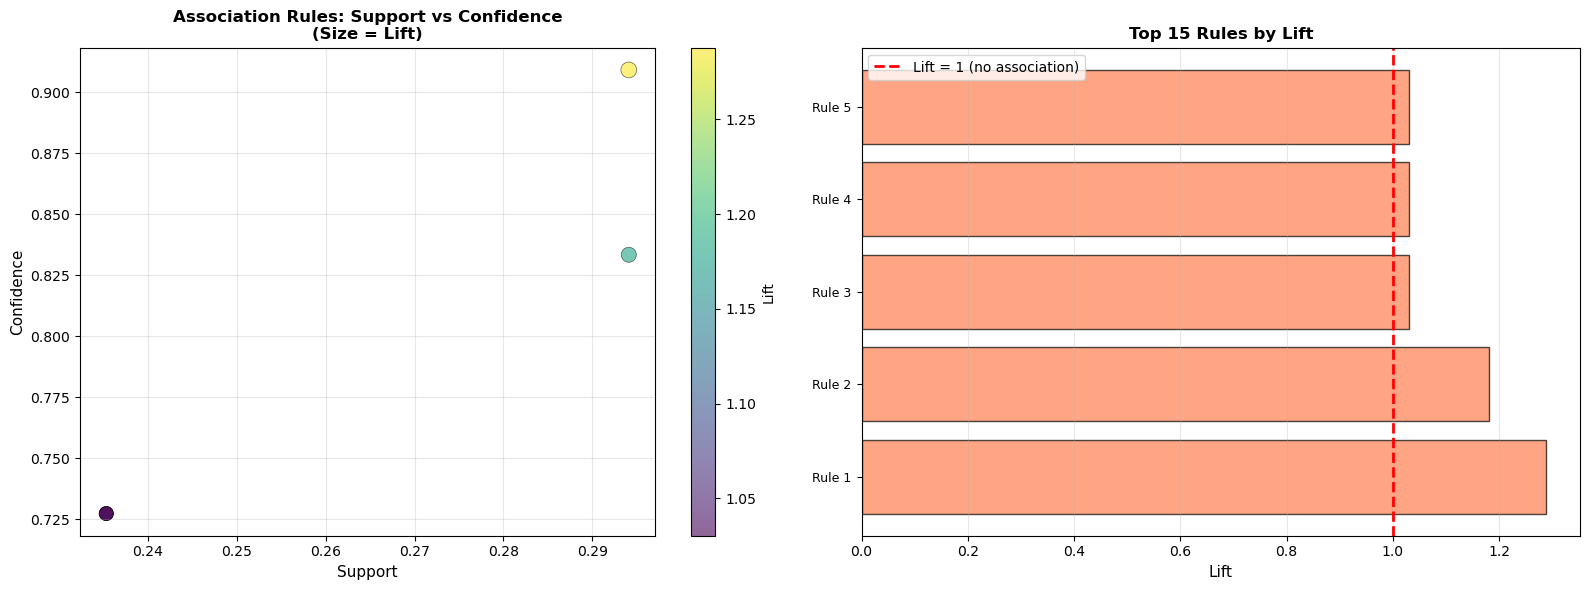

✓ 關聯規則視覺化完成


In [21]:
# 繪製關聯規則的 Support-Confidence 散佈圖
if len(rules) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Support vs Confidence (點的大小代表 Lift)
    scatter1 = axes[0].scatter(rules['support'], rules['confidence'], 
                              s=rules['lift']*100, alpha=0.6, 
                              c=rules['lift'], cmap='viridis', edgecolors='black', linewidth=0.5)
    axes[0].set_xlabel('Support', fontsize=11)
    axes[0].set_ylabel('Confidence', fontsize=11)
    axes[0].set_title('Association Rules: Support vs Confidence\n(Size = Lift)', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    cbar1 = plt.colorbar(scatter1, ax=axes[0])
    cbar1.set_label('Lift', fontsize=10)
    
    # Lift 排名 (Top 15)
    top_rules = rules.nlargest(15, 'lift')
    y_pos = np.arange(len(top_rules))
    axes[1].barh(y_pos, top_rules['lift'], color='coral', alpha=0.7, edgecolor='black')
    axes[1].set_yticks(y_pos)
    axes[1].set_yticklabels([f"Rule {i+1}" for i in range(len(top_rules))], fontsize=9)
    axes[1].set_xlabel('Lift', fontsize=11)
    axes[1].set_title('Top 15 Rules by Lift', fontsize=12, fontweight='bold')
    axes[1].axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Lift = 1 (no association)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'association_rules_viz.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ 關聯規則視覺化完成")
else:
    print("⚠️ 無規則可視覺化")

---
## 7. 最終結果：Top 5 候選溶劑

### 7.1 綜合評分與排名

In [22]:
# 建立綜合評分系統
# 評分 = 0.4 * PerformanceIndex + 0.3 * EconomicIndex + 0.3 * SafetyIndex
# 
# 【權重設定依據】
# - PerformanceIndex (40%): 最重要，直接影響萃取效率
# - EconomicIndex (30%): 次要，控制操作成本
# - SafetyIndex (30%): 次要，確保製程安全性
# - 實務中可根據具體需求調整權重 (如高風險製程增加SafetyIndex權重)

# 先標準化各指數 (0-1 scale)
from sklearn.preprocessing import MinMaxScaler
scaler_score = MinMaxScaler()

df_stage2['PI_scaled'] = scaler_score.fit_transform(df_stage2[['PerformanceIndex']])
df_stage2['EI_scaled'] = scaler_score.fit_transform(df_stage2[['EconomicIndex']])
df_stage2['SI_scaled'] = scaler_score.fit_transform(df_stage2[['SafetyIndex']])

# 計算綜合評分
df_stage2['CompositeScore'] = (0.4 * df_stage2['PI_scaled'] + 
                                0.3 * df_stage2['EI_scaled'] + 
                                0.3 * df_stage2['SI_scaled'])

# 排序取 Top 5
df_top5 = df_stage2.nlargest(5, 'CompositeScore')

print("=" * 100)
print("Top 5 候選溶劑")
print("=" * 100)

display_cols = ['SolventID', 'Solubility', 'BoilingPoint', 'Viscosity', 'Toxicity', 
                'Cost', 'PerformanceIndex', 'EconomicIndex', 'SafetyIndex', 'CompositeScore']

df_top5_display = df_top5[display_cols].copy()
df_top5_display['Rank'] = range(1, 6)
df_top5_display = df_top5_display[['Rank'] + display_cols]

print(df_top5_display.round(2).to_string(index=False))

print(f"\n✓ 最終篩選完成！")
print(f"  從 {len(df_solvents)} 種候選溶劑篩選至 Top 5")
print(f"  總篩選率: {(1 - 5/len(df_solvents))*100:.1f}% 被排除")

Top 5 候選溶劑
 Rank SolventID  Solubility  BoilingPoint  Viscosity  Toxicity  Cost  PerformanceIndex  EconomicIndex  SafetyIndex  CompositeScore
    1      S064       77.74         95.09       0.45         2  1.84             86.17          42.27        24.16            0.68
    2      S069       85.79        101.62       0.22         4  1.65             97.77          52.09         8.80            0.57
    3      S058       78.09         79.01       0.44         2  2.86             89.73          27.32        19.13            0.57
    4      S067       89.01         63.05       0.20         4  4.50            111.26          19.77         6.19            0.47
    5      S052      100.28         55.59       0.48         3  2.11             70.13          47.54        11.72            0.47

✓ 最終篩選完成！
  從 100 種候選溶劑篩選至 Top 5
  總篩選率: 95.0% 被排除


### 7.3 Top 5 溶劑詳細特性分析

In [23]:
# 建立詳細的 Top 5 比較表
all_feature_cols = feature_cols + ['PerformanceIndex', 'EconomicIndex', 'SafetyIndex', 'CompositeScore']

print("=" * 120)
print("Top 5 溶劑完整特性比較")
print("=" * 120)

df_top5_full = df_top5[['SolventID'] + all_feature_cols].copy()
df_top5_full.insert(0, 'Rank', range(1, 6))

print(df_top5_full.round(2).to_string(index=False))

# 各溶劑的優劣勢分析
print("\n" + "=" * 120)
print("各溶劑的優劣勢分析")
print("=" * 120)

for rank, (idx, row) in enumerate(df_top5.iterrows(), 1):
    print(f"\n【Rank {rank}: {row['SolventID']}】")
    
    # 找出此溶劑的優勢 (前 3 高的標準化特徵)
    advantages = []
    if row['Solubility'] > df_solvents['Solubility'].quantile(0.75):
        advantages.append(f"高溶解度 ({row['Solubility']:.1f} g/L)")
    if row['Viscosity'] < df_solvents['Viscosity'].quantile(0.25):
        advantages.append(f"低黏度 ({row['Viscosity']:.2f} cP)")
    if row['Toxicity'] <= 4:
        advantages.append(f"低毒性 (級別 {row['Toxicity']:.0f})")
    if row['Cost'] < df_solvents['Cost'].quantile(0.33):
        advantages.append(f"低成本 (${row['Cost']:.2f}/kg)")
    if 70 <= row['BoilingPoint'] <= 110:
        advantages.append(f"適中沸點 ({row['BoilingPoint']:.1f}°C)")
    
    print(f"  優勢: {', '.join(advantages) if advantages else 'N/A'}")
    
    # 找出此溶劑的劣勢
    disadvantages = []
    if row['Toxicity'] >= 6:
        disadvantages.append(f"毒性較高 (級別 {row['Toxicity']:.0f})")
    if row['Cost'] > df_solvents['Cost'].quantile(0.75):
        disadvantages.append(f"成本較高 (${row['Cost']:.2f}/kg)")
    if row['Viscosity'] > df_solvents['Viscosity'].quantile(0.75):
        disadvantages.append(f"黏度較高 ({row['Viscosity']:.2f} cP)")
    if row['BoilingPoint'] > 140:
        disadvantages.append(f"沸點較高 ({row['BoilingPoint']:.1f}°C)")
    
    print(f"  劣勢: {', '.join(disadvantages) if disadvantages else '無明顯劣勢'}")
    print(f"  綜合評分: {row['CompositeScore']:.3f}")

Top 5 溶劑完整特性比較
 Rank SolventID  Solubility  BoilingPoint  Viscosity  Density  Toxicity  Cost  Polarity  DielectricConstant  RefractiveIndex  FlashPoint  PerformanceIndex  EconomicIndex  SafetyIndex  CompositeScore
    1      S064       77.74         95.09       0.45     0.92         2  1.84      4.96               14.13             1.42       48.32             86.17          42.27        24.16            0.68
    2      S069       85.79        101.62       0.22     0.88         4  1.65      2.85               13.85             1.39       35.21             97.77          52.09         8.80            0.57
    3      S058       78.09         79.01       0.44     0.90         2  2.86      5.48               10.43             1.47       38.27             89.73          27.32        19.13            0.57
    4      S067       89.01         63.05       0.20     0.81         4  4.50      5.25               15.48             1.40       24.76            111.26          19.77         6.19       

### 7.2 Top 5 溶劑視覺化比較

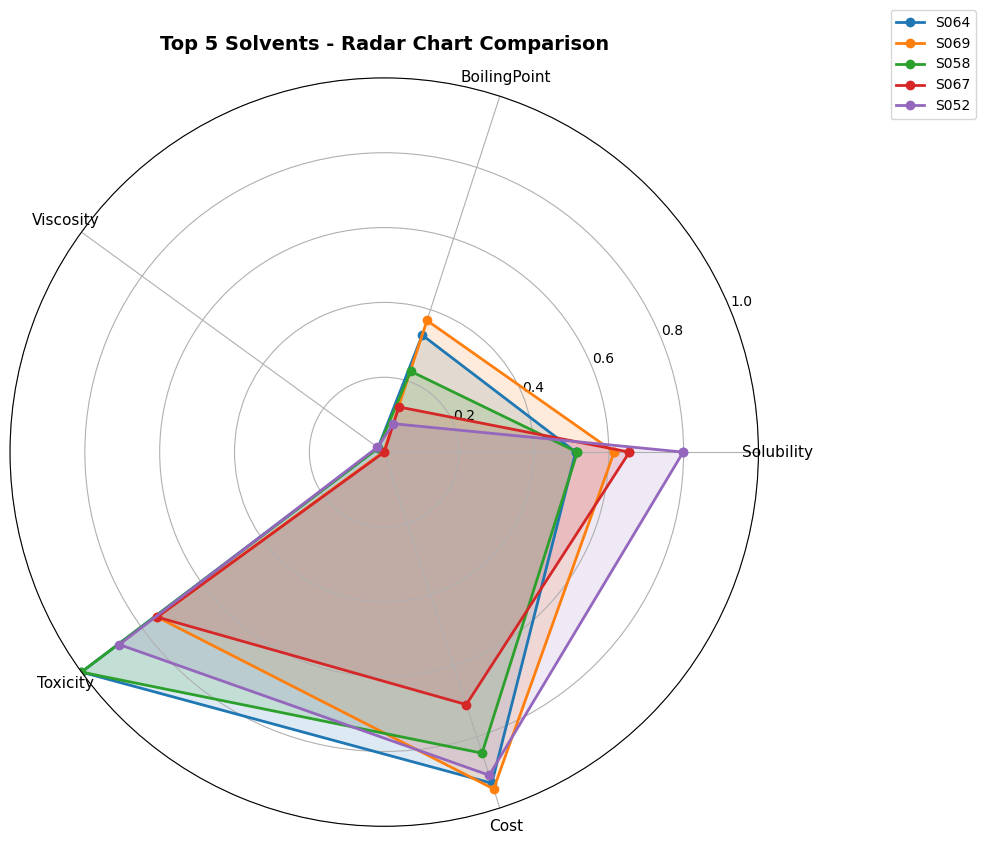

✓ 雷達圖已生成 (數值已標準化至 0-1，Toxicity 和 Cost 已反轉)


In [24]:
# 繪製 Top 5 溶劑的雷達圖比較
from math import pi

# 選擇關鍵特徵進行比較
radar_features = ['Solubility', 'BoilingPoint', 'Viscosity', 'Toxicity', 'Cost']
num_vars = len(radar_features)

# 標準化數據到 0-1 範圍 (用於雷達圖)
df_top5_normalized = df_top5.copy()
for col in radar_features:
    min_val = df_solvents[col].min()
    max_val = df_solvents[col].max()
    df_top5_normalized[col] = (df_top5[col] - min_val) / (max_val - min_val)
    
    # 對於 Toxicity 和 Cost，反轉分數 (越低越好)
    if col in ['Toxicity', 'Cost']:
        df_top5_normalized[col] = 1 - df_top5_normalized[col]

# 繪製雷達圖
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for idx, (i, row) in enumerate(df_top5_normalized.iterrows()):
    values = row[radar_features].values.tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=row['SolventID'], color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_features, fontsize=11)
ax.set_ylim(0, 1)
ax.set_title('Top 5 Solvents - Radar Chart Comparison', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax.grid(True)

plt.tight_layout()
plt.savefig(FIG_DIR / 'top5_radar_chart.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 雷達圖已生成 (數值已標準化至 0-1，Toxicity 和 Cost 已反轉)")

---
## 8. 完整篩選流程視覺化

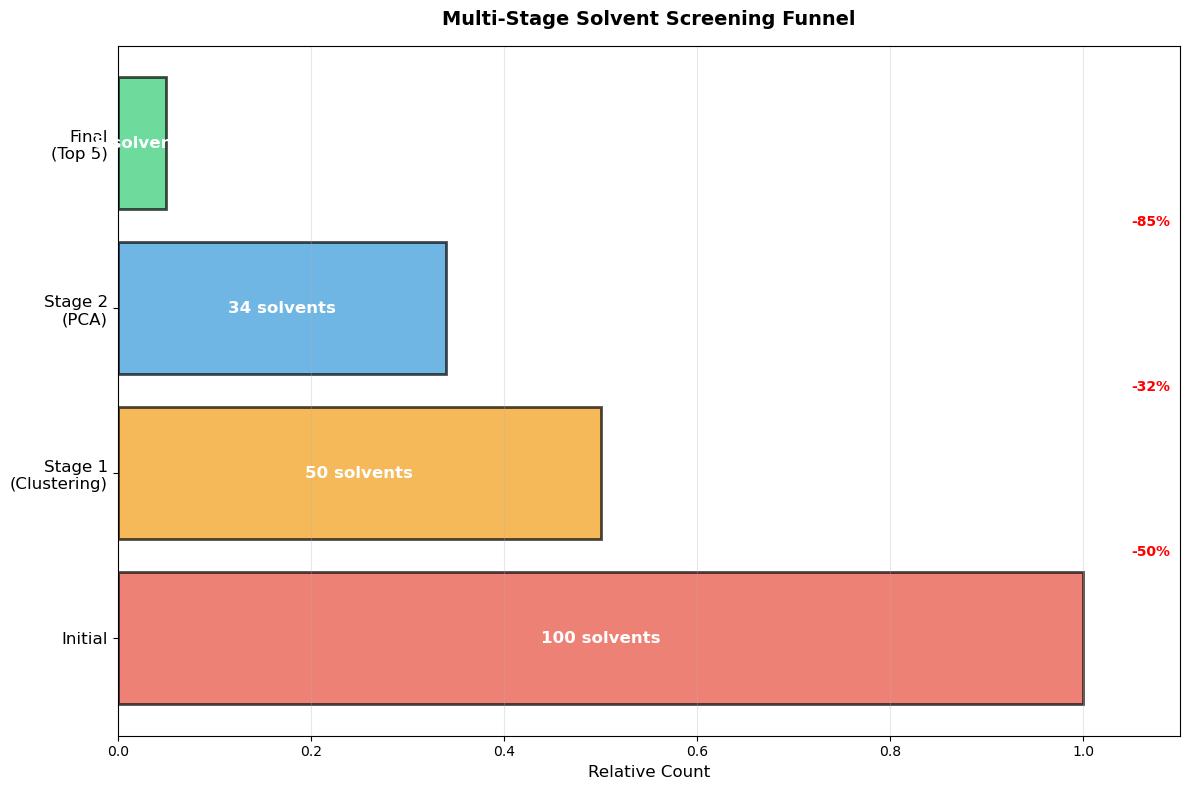

✓ 篩選漏斗流程圖已生成


In [25]:
# 繪製篩選漏斗流程圖
fig, ax = plt.subplots(figsize=(12, 8))

# 設定漏斗數據
stages = ['Initial', 'Stage 1\n(Clustering)', 'Stage 2\n(PCA)', 'Final\n(Top 5)']
counts = [len(df_solvents), len(df_stage1), len(df_stage2), 5]
colors_funnel = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']

# 繪製橫向漏斗
y_positions = np.arange(len(stages))
bar_widths = [count/max(counts) for count in counts]

bars = ax.barh(y_positions, bar_widths, color=colors_funnel, alpha=0.7, edgecolor='black', linewidth=2)

# 添加數量標籤
for i, (bar, count) in enumerate(zip(bars, counts)):
    ax.text(bar.get_width()/2, bar.get_y() + bar.get_height()/2, 
            f'{count} solvents', ha='center', va='center', fontsize=12, fontweight='bold', color='white')

ax.set_yticks(y_positions)
ax.set_yticklabels(stages, fontsize=12)
ax.set_xlabel('Relative Count', fontsize=12)
ax.set_title('Multi-Stage Solvent Screening Funnel', fontsize=14, fontweight='bold', pad=15)
ax.set_xlim(0, 1.1)
ax.grid(True, alpha=0.3, axis='x')

# 添加篩選率標註
for i in range(len(counts)-1):
    reduction_rate = (counts[i] - counts[i+1]) / counts[i] * 100
    ax.text(1.05, (y_positions[i] + y_positions[i+1])/2, 
            f'-{reduction_rate:.0f}%', fontsize=10, color='red', fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / 'screening_funnel.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 篩選漏斗流程圖已生成")

---
## 9. 方法論總結與洞察

### 9.1 三種方法的協同效果

In [26]:
# 總結三種方法的貢獻
summary_data = {
    'Method': ['Clustering', 'PCA', 'Composite Scoring'],
    'Input': [100, len(df_stage1), len(df_stage2)],
    'Output': [len(df_stage1), len(df_stage2), 5],
    'Key Insight': [
        'Identified 4 solvent families',
        'Visualized performance in 2D space',
        'Ranked by multi-objective score'
    ],
    'Reduction Rate': [
        f"{(1 - len(df_stage1)/100)*100:.1f}%",
        f"{(1 - len(df_stage2)/len(df_stage1))*100:.1f}%",
        f"{(1 - 5/len(df_stage2))*100:.1f}%"
    ]
}

df_summary = pd.DataFrame(summary_data)

print("=" * 100)
print("篩選方法協同效果總結")
print("=" * 100)
print(df_summary.to_string(index=False))

print(f"\n✓ 總體篩選效率:")
print(f"  最終保留: 5 / {len(df_solvents)} = {5/len(df_solvents)*100:.1f}%")
print(f"  排除率: {(1 - 5/len(df_solvents))*100:.1f}%")
print(f"\n✓ 這 5 種溶劑是經過 3 階段、多維度評估後的最佳候選，可優先進行實驗驗證！")

篩選方法協同效果總結
           Method  Input  Output                        Key Insight Reduction Rate
       Clustering    100      50      Identified 4 solvent families          50.0%
              PCA     50      34 Visualized performance in 2D space          32.0%
Composite Scoring     34       5    Ranked by multi-objective score          85.3%

✓ 總體篩選效率:
  最終保留: 5 / 100 = 5.0%
  排除率: 95.0%

✓ 這 5 種溶劑是經過 3 階段、多維度評估後的最佳候選，可優先進行實驗驗證！


---
## 10. 儲存結果

將 Top 5 溶劑資訊儲存為 CSV 檔案供後續使用。

In [27]:
# 儲存 Top 5 溶劑資訊
output_file = OUTPUT_DIR / 'Top5_Solvents.csv'
df_top5[display_cols].to_csv(output_file, index=False)

print(f"✓ Top 5 溶劑資訊已儲存至: {output_file}")

# 儲存完整篩選歷程
screening_history = {
    'Stage 0 - Initial': len(df_solvents),
    'Stage 1 - After Clustering': len(df_stage1),
    'Stage 2 - After PCA': len(df_stage2),
    'Stage 3 - Top 5': 5
}

history_df = pd.DataFrame(list(screening_history.items()), columns=['Stage', 'Count'])
history_file = OUTPUT_DIR / 'Screening_History.csv'
history_df.to_csv(history_file, index=False)

print(f"✓ 篩選歷程已儲存至: {history_file}")
print(f"\n所有圖檔已儲存至: {FIG_DIR}")
print(f"  - correlation_matrix.png")
print(f"  - clustering_evaluation.png")
print(f"  - pca_scatter.png")
print(f"  - top5_radar_chart.png")
print(f"  - screening_funnel.png")

✓ Top 5 溶劑資訊已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Solvent_Screening\Top5_Solvents.csv
✓ 篩選歷程已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Solvent_Screening\Screening_History.csv

所有圖檔已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Solvent_Screening\figs
  - correlation_matrix.png
  - clustering_evaluation.png
  - pca_scatter.png
  - top5_radar_chart.png
  - screening_funnel.png


---
## 總結

### 學習重點回顧

**本案例展示了**：

1. **多方法協同**：Clustering → PCA → Composite Scoring 的三階段篩選流程
2. **數據驅動決策**：從 100 種溶劑系統性篩選至 Top 5，而非依賴主觀經驗
3. **視覺化洞察**：透過相關性矩陣、PCA 散佈圖、雷達圖等多角度理解數據
4. **工程權衡**：在性能、安全、成本之間找到平衡點

### 核心技能

- ✓ 掌握了非監督式學習方法的組合應用
- ✓ 學會了設計多階段篩選策略
- ✓ 理解了如何將 AI 洞察轉化為工程決策
- ✓ 培養了數據驅動的化工問題解決能力

### 下一步建議

1. **實驗驗證**：對 Top 5 溶劑進行實際萃取實驗
2. **參數調整**：嘗試不同的篩選閾值，觀察結果變化
3. **方法擴展**：加入更多特徵 (如環境友好性指標)
4. **應用遷移**：將此方法論應用到催化劑篩選、配方優化等其他場景

**恭喜完成溶劑篩選綜合案例研究！**